In [24]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image
from scipy import stats


# Définir ZERO_CELSIUS (conversion Celsius vers Kelvin)
ZERO_CELSIUS = 273.15


chemins de fichiers :

In [25]:
# define the folder path
folder = r'D:\Documents\MINES\2A\MOLONARI\MOLONARI1D\dataAnalysis/'

# read in our data
path_files = folder + 'raw_data/'
path_config= folder + 'configuration/pressure_sensors/'
contenuDossier = os.listdir(path_files)
print(contenuDossier)

['.DS_Store', 'point13_29_07_15', 'point14_29_07_15', 'point15_29_07_15', 'point34_27_06_16', 'point35_07_12_16', 'point36_12_07_16', 'point46_17_06_19', 'point47_27_08_19', 'point48_14_04_18', 'point52_13_10_23', 'point53_13_10_23', 'schema_dispositif_AvAv_23_07_15.png']


In [26]:
point='point35_07_12_16/'
# le chemin vers le dossier
chemin = path_files + point
# Spécifiez le chemin de votre fichier PNG
chemin_image = chemin + point.split('_')[0] + '_schema.png'

fonction utile

In [27]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

In [28]:
read_csv(chemin + "Point035_info.csv").head()

,Point_Name,Point035
0,P_Sensor_Name,P505
1,Shaft_Name,S003
2,Implantation_Date,2016/07/12 11:00:00
3,Meas_Date,2016/08/03 11:00:00
4,River_Bed,0.155


Structure de données

In [29]:

# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
dico = {}
# le chemin vers le dossier
dico['chemin'] = path_files + point

with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
    lignes = fichier.readlines()
    # le nom du capteur
    dico['capteur'] = lignes[1][:4]
    # la profondeur du capteur
    if lignes[3] == '\n' :
        dico['profondeur'] = 0
    else : 
        dico['profondeur'] = lignes[3]
        # les profondeurs auxquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))


    # on va ensuite mettre les dataframes dans le dictionnaire
contenuDossierPoint = os.listdir(dico['chemin'])
for x in contenuDossierPoint:
    # la pression
    if x=="point35_pression_cleaned.csv":
        dico['pression'] = read_csv(dico['chemin'] + '/' + x)
    # la température
    if x=="point35_temperature_cleaned.csv":
        dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
with open(path_config + dico['capteur'].upper() + '.csv') as fichier:
    lignes = fichier.readlines()
    for l in lignes:
        if l.startswith('Intercept'):
            dico['intercept'] = float(l[10:-2])
        if l.startswith('dU/dH'):
            dico['dU/dH'] = float(l[6:-2])
        if l.startswith('dU/dT'):
            dico['dU/dT'] = float(l[6:-2]) 



Renommage des colonnes

In [30]:
# Renommage 

dico['temperature'].rename(columns={'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164)': 'temperature_depth_1_C'   ,    'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).1': 'temperature_depth_2_C','Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).2': 'temperature_depth_3_C','Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).3': 'temperature_depth_4_C', 'Date Heure, GMT+01:00': 'dates' }, inplace=True)
dico['pression'].rename(columns={'Date Heure, GMT+01:00': 'dates'   ,    'Tension, V (LGR S/N: 10445475, SEN S/N: 10445475, LBL: température)': 'tension_V'   ,   'Temp., °C (LGR S/N: 10445475, SEN S/N: 10445475, LBL: Température)' : 'temperature_stream_C'}, inplace=True)

print("Colonnes température:", dico['temperature'].columns.tolist())
print("Colonnes pression:", dico['pression'].columns.tolist())

Colonnes température: ['dates', 'Temp_profondeur_10', 'Temp_profondeur_20', 'Temp_profondeur_30', 'Temp_profondeur_40']
Colonnes pression: ['dates', 'temperature_stream', 'dH']


Changer le format des dates

In [31]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = dico['pression'][dico['pression'].columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

In [32]:
convertDates(dico['temperature'])
convertDates(dico['pression'])
dico['temperature']['dates'].dtype
dico['pression']['dates'].dtype


ValueError: Cannot convert dates: No known formats match your data!

Suppression des NAN

In [ ]:
dico['temperature'] = dico['temperature'].dropna(axis = 0, how = 'any')
dico['pression'] = dico['pression'].dropna(axis = 0, how='any')

Tracé des températures

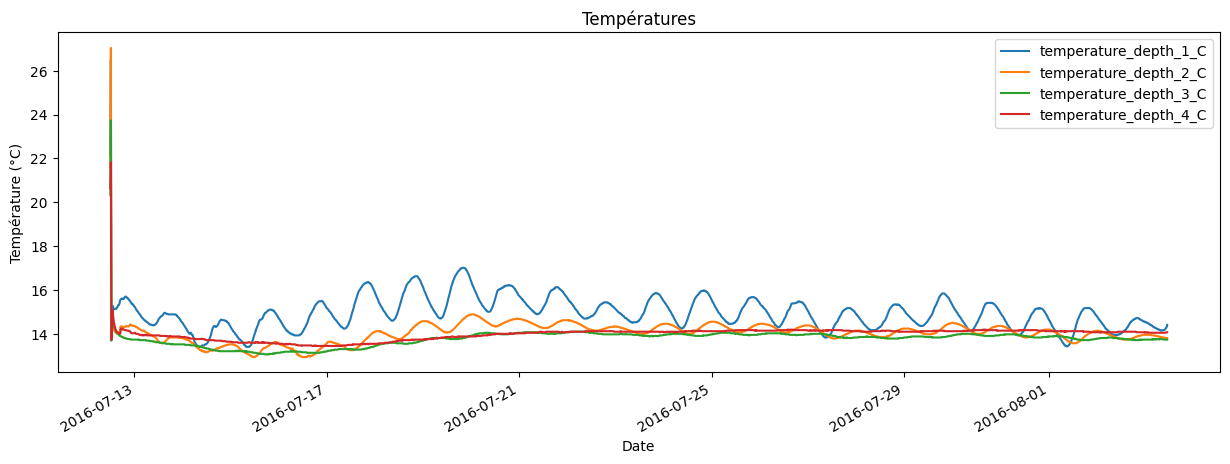

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

dico['temperature'].plot(x='dates', y=['temperature_depth_1_C', 'temperature_depth_2_C', 'temperature_depth_3_C', 'temperature_depth_4_C'], ax=ax)

plt.title('Températures')
plt.xlabel('Date')
plt.ylabel('Température (°C)')

plt.show()


## Fourier

In [ ]:
from numpy.fft import fft, fftfreq

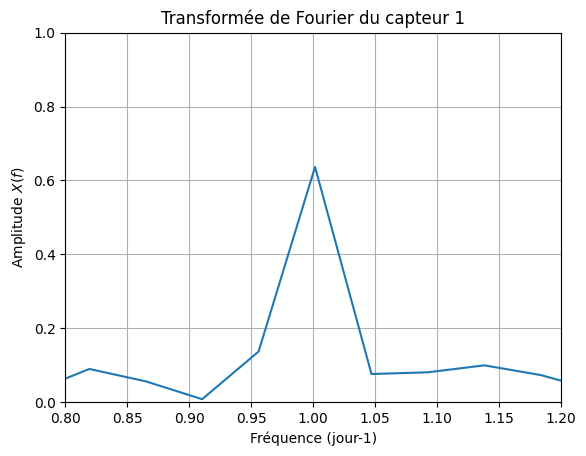

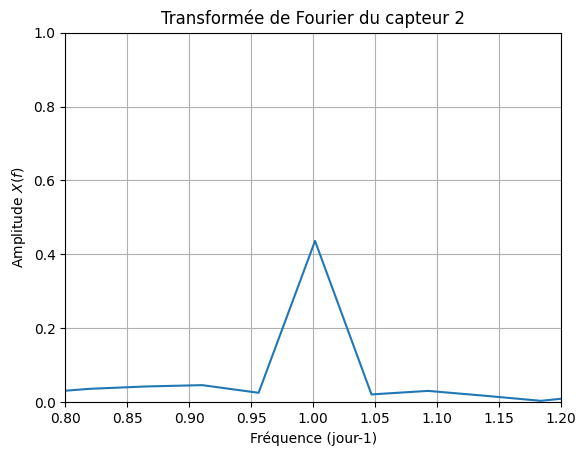

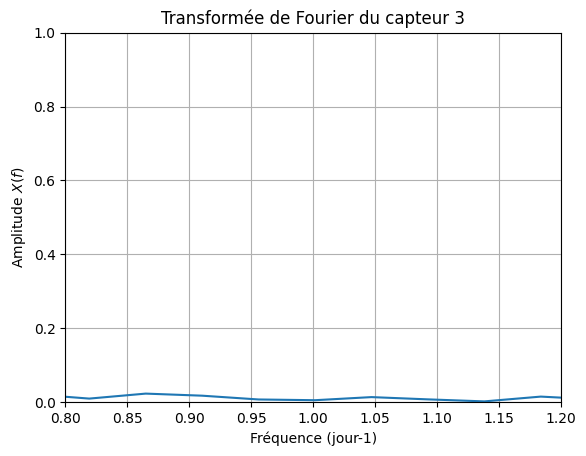

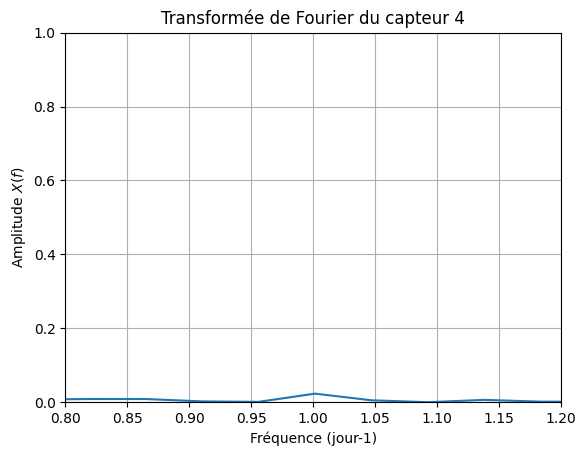

In [ ]:
for i in range(1,dico['temperature'].shape[1]):

    temp_brut=dico['temperature'].iloc[:, i]
    moyenne=temp_brut.mean()
    for temp in temp_brut:
        temp-=moyenne
    X = np.fft.rfft(temp_brut[2:])  # Transformée de fourier
    freq = np.fft.rfftfreq(len(temp_brut[2:]), d=0.25/24)  # Fréquences de la transformée de Fourier en jour^-1
    amp = (2/len(X)) * np.abs(X.real)  

    plt.plot(freq, amp, label="Partie réelle")
    plt.grid()
    plt.xlim(0.8,1.2)
    plt.ylim(0,1)
    plt.xlabel(r"Fréquence (jour-1)")
    plt.ylabel(r"Amplitude $X(f)$")
    plt.title(f"Transformée de Fourier du capteur {i}")
    plt.show()